# Test Angular proposal

The `Angular` proposal is meant to be used for parameters that are cyclic $\in [0, 2\pi)$. It works by using a truncated normal distribution for the jump proposal. For any point $\phi \in [0, 2\pi)$ a jump is produced by drawing a $\Delta \phi$ from the truncated normal with zero mean and bounds at $+/- \pi$. The $\Delta\phi$ is added to $\phi$, then cyclic boundaries are applied so that the new point is within $[0, 2\pi)$; i.e.,

\begin{equation}
\phi' = (\phi + \Delta \phi)\mod 2\pi.
\end{equation}

This type of proposal is particularly useful for problems in which the phase of a signal needs to be estimated. As is demonstrated below, the angular proposal for such a model is much more efficient than the standard normal proposal when the parameter that is being estimated is close to either $0$ or $2\pi$.

In [1]:
%matplotlib notebook
from matplotlib import pyplot
from epsie.proposals import (Angular, Normal, Boundaries)
import numpy
from scipy import stats

## 1D Test

In [2]:
class AngularModel(object):

    def __init__(self, phi0=0., std=1.):
        self.phi0 = phi0
        self.params = ['phi']
        self.std = numpy.array([std])
        # we'll just use a uniform prior
        self.prior_bounds = {'phi': Boundaries((0., 2*numpy.pi))}
        pmin = self.prior_bounds['phi'].lower
        dp = abs(self.prior_bounds['phi'])
        self.prior_dist = {'phi': stats.uniform(pmin, dp)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}

    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])

    def loglikelihood(self, **kwargs):
        # apply cyclic bounds to xi to put in [0, 2\pi]
        xi = numpy.array([kwargs[p] for p in self.params]) % (2*numpy.pi)
        # shift xi by the amounted needed to move phi0 to the cetner of [0, 2\pi),
        # and apply bounds again
        dphi = numpy.pi - self.phi0
        xi = (xi + dphi) % (2*numpy.pi)
        # now use a truncated normal centered on pi
        b = numpy.pi/self.std
        a = -b
        return stats.truncnorm.logpdf(xi, a, b, loc=numpy.pi, scale=self.std).sum()

    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp


In [3]:
model = AngularModel()

In [4]:
prop = Angular(model.params)
# we'll compare to a normal proposal
norm_prop = Normal(model.params, cov=prop.cov)

In [5]:
# create 3 points to test, one on the edges and one in the middle
pmin, pmax = model.prior_bounds['phi']
test_points = numpy.array([pmin, (pmin+pmax)/2, pmax])

In [6]:
# test that jumps are all in bounds, and compare to norm
njumps = 1000
jumps = numpy.zeros((len(test_points), njumps))
norm_jumps = numpy.zeros((len(test_points), njumps))
for ii, xi in enumerate(test_points):
    jumps[ii,:] = numpy.array([prop.jump({'phi': xi})['phi']
                               for _ in range(njumps)])
    norm_jumps[ii,:] = numpy.array([norm_prop.jump({'phi': xi})['phi']
                                    for _ in range(njumps)])

In [7]:
# check that none of the jumps are out of bounds
print('Any jumps out of bounds?')
print('angular:', ((jumps < pmin) | (jumps > pmax)).any())
# compare to norm
print('normal:', ((norm_jumps < pmin) | (norm_jumps > pmax)).any())

Any jumps out of bounds?
angular: False
normal: True


In [8]:
# test the pdfs
pdfs = numpy.zeros(jumps.shape)
norm_pdfs = numpy.zeros(norm_jumps.shape)
for ii, xi in enumerate(test_points):
    pdfs[ii, :] = numpy.array([prop.pdf({'phi': tox}, {'phi': xi})
                               for tox in jumps[ii, :]])
    norm_pdfs[ii, :] = numpy.array([norm_prop.pdf({'phi': tox}, {'phi': xi})
                                    for tox in norm_jumps[ii, :]])

<IPython.core.display.Javascript object>


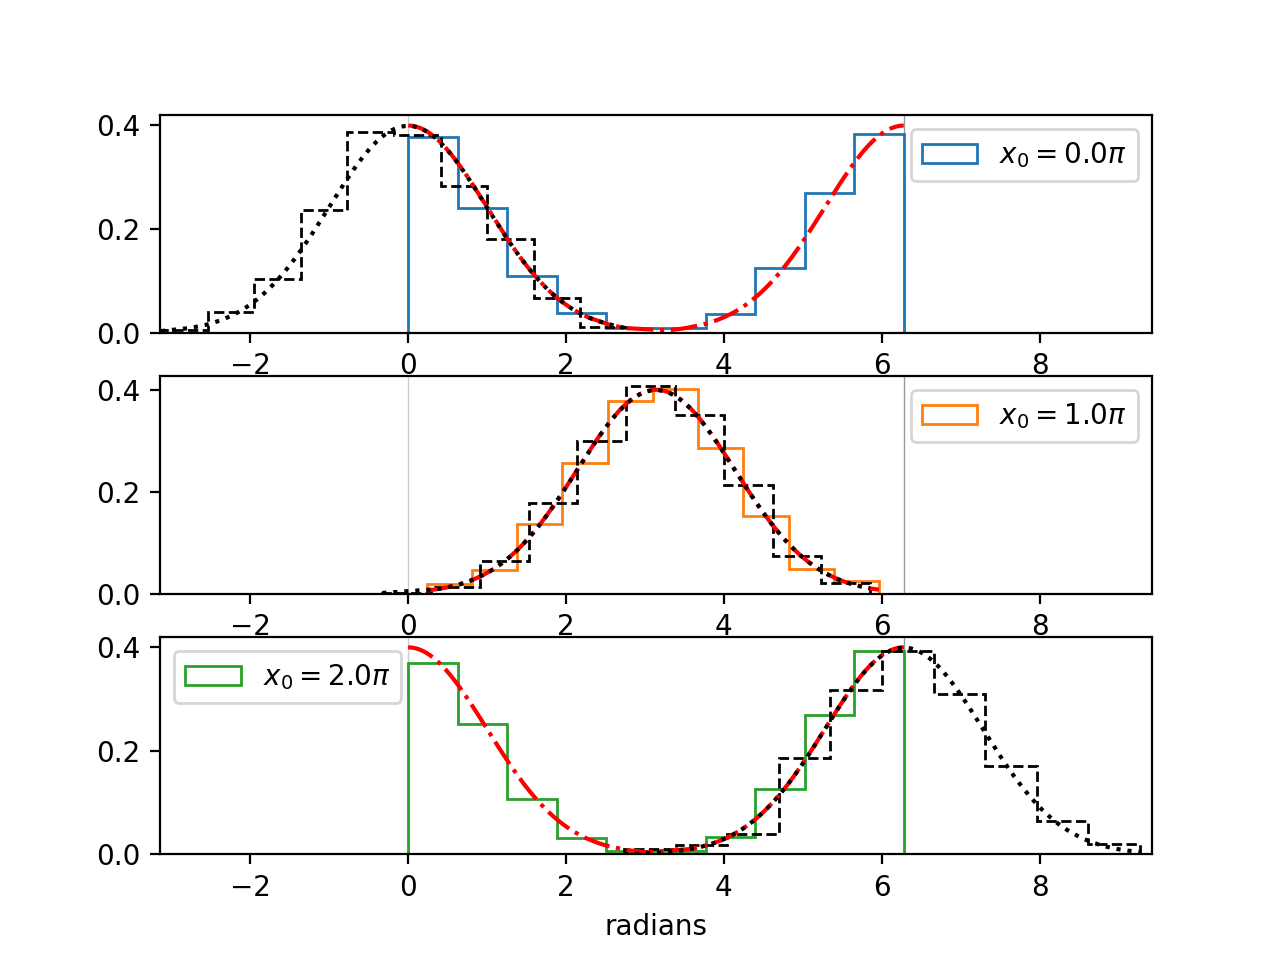

In [9]:
# plot them
fig, axes = pyplot.subplots(nrows=3)
for ii, xi in enumerate(test_points):
    ax=axes[ii]
    color = 'C{}'.format(ii)
    ax.hist(jumps[ii,:], density=True, histtype='step',
            color=color, label=r'$x_0 = {}\pi$'.format(xi/numpy.pi))
    sortidx = jumps[ii, :].argsort()
    ax.plot(jumps[ii, :][sortidx], pdfs[ii, :][sortidx], color='r', ls='-.')
    ax.hist(norm_jumps[ii,:], density=True, histtype='step',
            linestyle='dashed', color='black')
    sortidx = norm_jumps[ii, :].argsort()
    ax.plot(norm_jumps[ii, :][sortidx], norm_pdfs[ii, :][sortidx],
            color='black', ls=':')
    ax.axvline(0., color='black', alpha=0.2, lw=0.5, zorder=-1)
    ax.axvline(2*numpy.pi, color='black', alpha=0.4, lw=0.5, zorder=-1)    
    ax.set_xlim(-numpy.pi, 3*numpy.pi)
    ax.legend()
ax.set_xlabel(r'radians')
fig.show()

## Comparison to Normal proposal: 1D

In [10]:
from epsie.samplers import MetropolisHastingsSampler
import multiprocessing

In [11]:
nchains = 12
nprocs = 4
pool = multiprocessing.Pool(nprocs)

In [12]:
model = AngularModel()

In [13]:
prop = Angular(model.params)
# we'll compare to a normal proposal
norm_prop = Normal(model.params, cov=prop.cov)

In [14]:
sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                    proposals=[prop])
sampler.start_position = model.prior_rvs(size=nchains)

sampler_norm = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                         proposals=[norm_prop])
sampler_norm.start_position = sampler.start_position

In [15]:
print(sampler.chains[0].proposal_dist.proposals)
print(sampler_norm.chains[0].proposal_dist.proposals)

(<epsie.proposals.angular.Angular object at 0x11de095c0>,)
(<epsie.proposals.normal.Normal object at 0x11de0bda0>,)


In [16]:
# run both for some iterations
sampler.run(4096)
sampler_norm.run(4096)

In [17]:
def calculate_acf(data, normalize=True):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+numpy.ceil(numpy.log2(len(data)))))
    x = numpy.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = numpy.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    if normalize:
        acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*numpy.cumsum(acf) - 1.
    win = m * cacf <= numpy.arange(len(cacf))
    if win.any():
        acl = int(numpy.ceil(cacf[numpy.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl

In [18]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples['phi'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = calculate_acl(sx)
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['phi'].append(sx[::-1][::acl][::-1])

In [19]:
print(acls, acls.mean())

[4 4 4 4 3 5 3 4 5 3 4 4] 3.9166666666666665


In [20]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples_norm = sampler_norm.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler_norm.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls_norm = numpy.zeros(nchains, dtype=int)
thinned_arrays_norm = {'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples_norm['phi'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = calculate_acl(sx)
    acls_norm[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays_norm['phi'].append(sx[::-1][::acl][::-1])

In [21]:
print(acls_norm, acls_norm.mean())

[ 60 241  87  91 250  97  72 204 231  66 100 186] 140.41666666666666


In [22]:
# create a flattened posterior array
posterior = {'phi': numpy.concatenate(thinned_arrays['phi'])}
print("Number of independent samples:", posterior['phi'].size)

Number of independent samples: 6453


In [23]:
# create a flattened posterior array
posterior_norm = {'phi': numpy.concatenate(thinned_arrays_norm['phi'])}
print("Number of independent samples:", posterior_norm['phi'].size)

Number of independent samples: 236


<IPython.core.display.Javascript object>


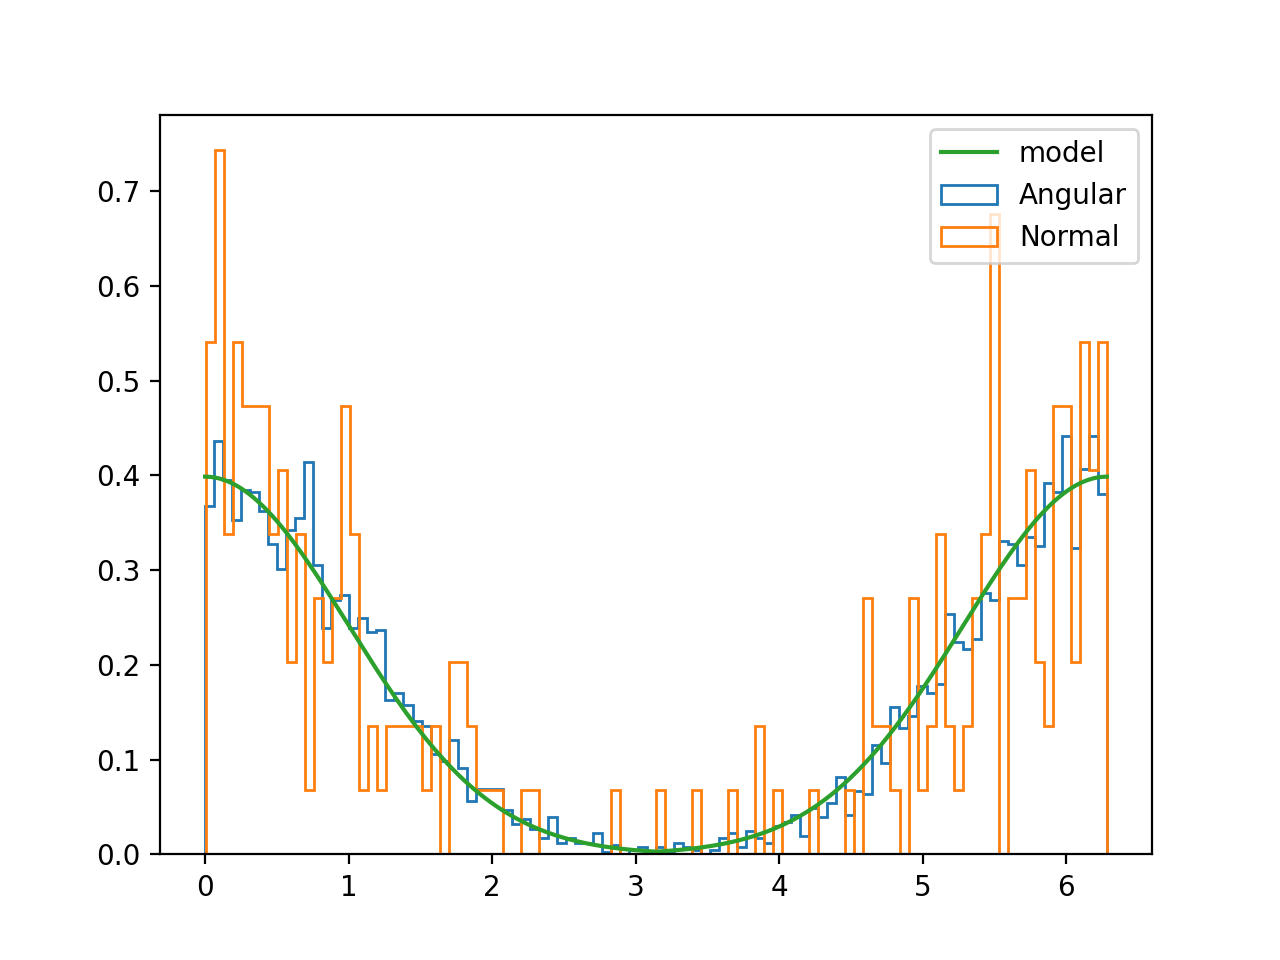

In [24]:
fig, ax = pyplot.subplots()
ax.hist(posterior['phi'], histtype='step', bins=100, density=True, label='Angular')
ax.hist(posterior_norm['phi'], histtype='step', bins=100, density=True, label='Normal')
xpts = numpy.linspace(model.prior_bounds['phi'][0], model.prior_bounds['phi'][1],
                      num=1000)
postpdf = numpy.exp(numpy.array([sum(model(phi=pt)) for pt in xpts]))
norm = (numpy.diff(xpts)[0] * postpdf).sum()
ax.plot(xpts, postpdf/norm, label='model')
ax.set_label('phi')
ax.legend()
fig.show()

In [25]:
ar = sampler.acceptance['acceptance_ratio']
ar[ar > 1] = 1.
ar.mean()

0.7107558121194725

In [26]:
ar_norm = sampler_norm.acceptance['acceptance_ratio']
ar_norm[ar_norm > 1] = 1.
ar_norm.mean()

0.5074951655351225

## Timing comparison

In [27]:
model = AngularModel()

sampler = MetropolisHastingsSampler(model.params, model, 1, pool=None,
                                   proposals=[prop])
sampler.start_position = model.prior_rvs(size=nchains)

sampler_norm = MetropolisHastingsSampler(model.params, model, 1, pool=None)
sampler_norm.start_position = sampler.start_position

In [28]:
print(sampler.chains[0].proposal_dist.proposals)
print(sampler_norm.chains[0].proposal_dist.proposals)

(<epsie.proposals.angular.Angular object at 0x11de094e0>,)
(<epsie.proposals.normal.Normal object at 0x11de2b518>,)


In [29]:
%timeit sampler.run(1)

528 µs ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%timeit sampler_norm.run(1)

403 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2D test

In this test, we'll run a 2D model $A e^{i\phi}$ in which the phase $\phi$ is a truncated normal distribution centered on 0, and the amplitude is $\beta$ distribution peaked toward 1.

In [31]:
from epsie.proposals import BoundedNormal

In [32]:
import numpy
from scipy import stats

class PolarModel(object):

    def __init__(self, phi0=0.):
        self.phi0 = 0.
        self.phi_std = 0.5
        self.params = ['amp', 'phi']
        a, b = 10, 2
        self.ampdist = stats.beta(a, b)
        # we'll just use a uniform prior
        self.prior_bounds = {
            'amp': Boundaries((0, 1.)),
            'phi': Boundaries((0., 2*numpy.pi))}
        self.prior_dist = {'phi': stats.uniform(0., 2*numpy.pi),
                           'amp': stats.uniform(0., 1.)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}

    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])

    def _logpdf_phi(self, xi):
        # apply cyclic bounds to xi to put in [0, 2\pi]
        xi = xi % (2*numpy.pi)
        # shift xi by the amounted needed to move phi0 to the cetner of [0, 2\pi),
        # and apply bounds again
        dphi = numpy.pi - self.phi0
        xi = (xi + dphi) % (2*numpy.pi)
        # now use a truncated normal centered on pi
        b = numpy.pi/self.phi_std
        a = -b
        return stats.truncnorm.logpdf(xi, a, b, loc=numpy.pi, scale=self.phi_std).sum()
        
    def loglikelihood(self, **kwargs):
        return self.ampdist.logpdf(kwargs['amp']) + self._logpdf_phi(kwargs['phi'])

    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp


In [33]:
model = PolarModel()

<IPython.core.display.Javascript object>


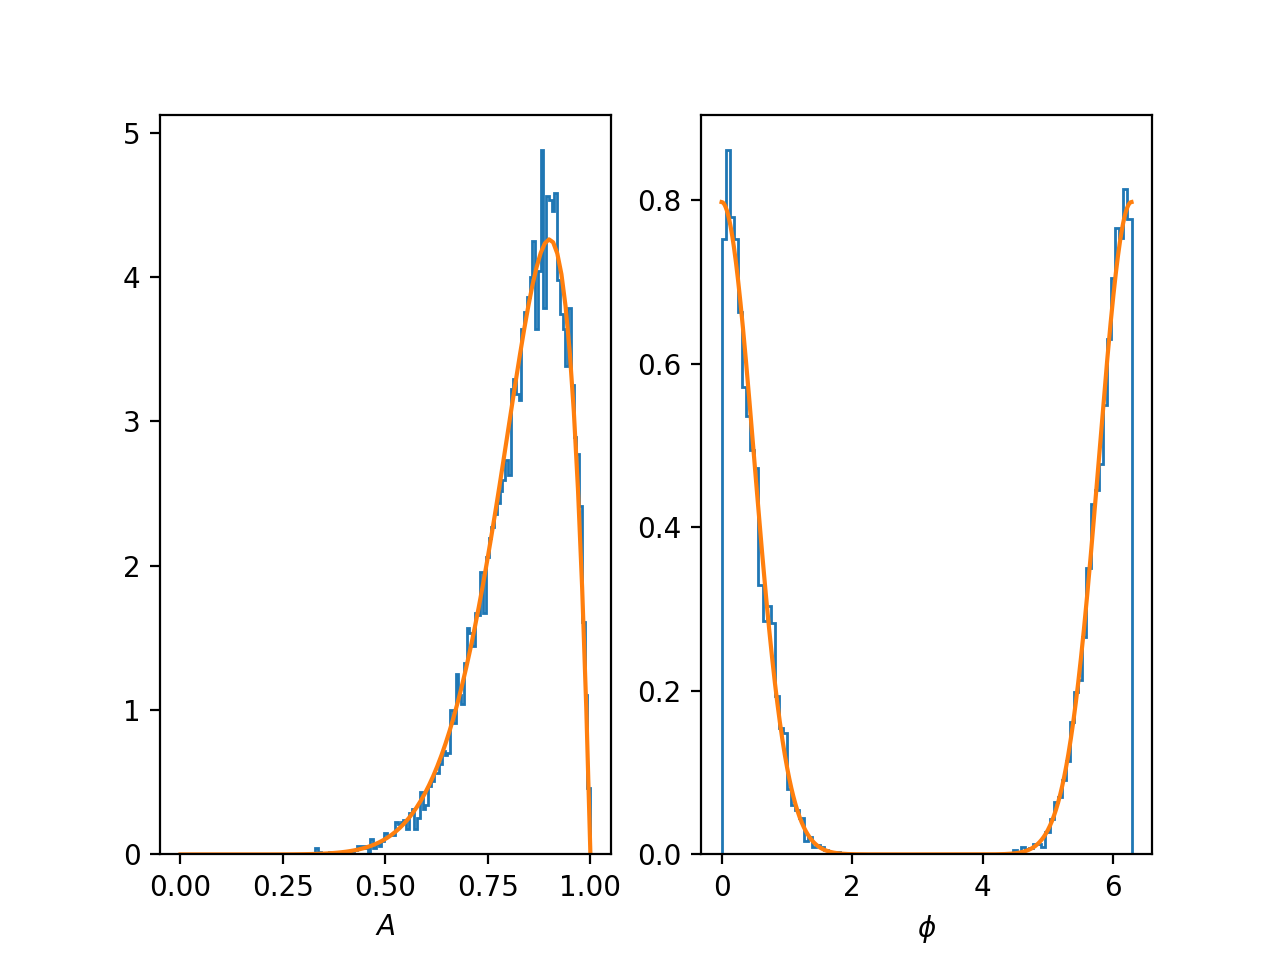

In [34]:
phis = numpy.linspace(0, 2*numpy.pi, num=1000)
amps = numpy.linspace(0, 1, num=100)
arvs = model.ampdist.rvs(size=10000)
prvs = stats.truncnorm.rvs(-numpy.pi/model.phi_std, numpy.pi/model.phi_std,
                           loc=0, scale=model.phi_std, size=10000)
prvs[prvs < 0] += 2*numpy.pi
fig, (ax1, ax2) = pyplot.subplots(ncols=2)
ax1.hist(arvs,  histtype='step', bins=100, density=True)
ax1.plot(amps, model.ampdist.pdf(amps))
ax1.set_xlabel('$A$')
ax2.hist(prvs, histtype='step', bins=100, density=True)
ax2.plot(phis, numpy.exp(numpy.array([model._logpdf_phi(p) for p in phis])))
ax2.set_xlabel('$\phi$')
fig.show()

In [35]:
phiprop = Angular(['phi'])
ampprop = BoundedNormal(['amp'], boundaries={'amp': model.prior_bounds['amp']})
# we'll compare to a normal proposal
phiprop_norm = Normal(['phi'], cov=phiprop.cov)
ampprop_norm = Normal(['amp'], cov=ampprop.cov)

In [36]:
pool.close()
pool = multiprocessing.Pool(nprocs)

sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                    proposals=[ampprop, phiprop])
sampler.start_position = model.prior_rvs(size=nchains)

sampler_norm = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                         proposals=[ampprop_norm, phiprop_norm])
sampler_norm.start_position = sampler.start_position

In [37]:
print(sampler.chains[0].proposal_dist.proposals)
print(sampler_norm.chains[0].proposal_dist.proposals)

(<epsie.proposals.bounded_normal.BoundedNormal object at 0x11de58438>, <epsie.proposals.angular.Angular object at 0x11de585f8>)
(<epsie.proposals.normal.Normal object at 0x11de09470>, <epsie.proposals.normal.Normal object at 0x11de09a20>)


In [38]:
# run both for some iterations
sampler.run(4096)
sampler_norm.run(4096)

In [39]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'amp': [], 'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sp = samples['phi'][ii, burnin_iter:]
    sa = samples['amp'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = max(calculate_acl(sp), calculate_acl(sa))
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['amp'].append(sa[::-1][::acl][::-1])
    thinned_arrays['phi'].append(sp[::-1][::acl][::-1])

In [40]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples_norm = sampler_norm.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler_norm.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls_norm = numpy.zeros(nchains, dtype=int)
thinned_arrays_norm = {'amp': [], 'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sp = samples_norm['phi'][ii, burnin_iter:]
    sa = samples_norm['amp'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = max(calculate_acl(sp), calculate_acl(sa))
    acls_norm[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays_norm['amp'].append(sa[::-1][::acl][::-1])
    thinned_arrays_norm['phi'].append(sp[::-1][::acl][::-1])

In [41]:
print(acls, acls.mean())

[12 10 22 19 10 10 11 13 18 16 14 15] 14.166666666666666


In [42]:
print(acls_norm, acls_norm.mean())

[ 46 103  86  71  63  58 256  44 147  53 176  94] 99.75


In [43]:
samples.shape

(12, 4096)

In [44]:
# create a flattened posterior array
posterior = {'amp': numpy.concatenate(thinned_arrays['amp']),
             'phi': numpy.concatenate(thinned_arrays['phi'])}
print("Number of independent samples:", posterior['phi'].size)

Number of independent samples: 1859


In [45]:
# create a flattened posterior array
posterior_norm = {'amp': numpy.concatenate(thinned_arrays_norm['amp']),
                  'phi': numpy.concatenate(thinned_arrays_norm['phi'])}
print("Number of independent samples:", posterior_norm['phi'].size)

Number of independent samples: 329


<IPython.core.display.Javascript object>


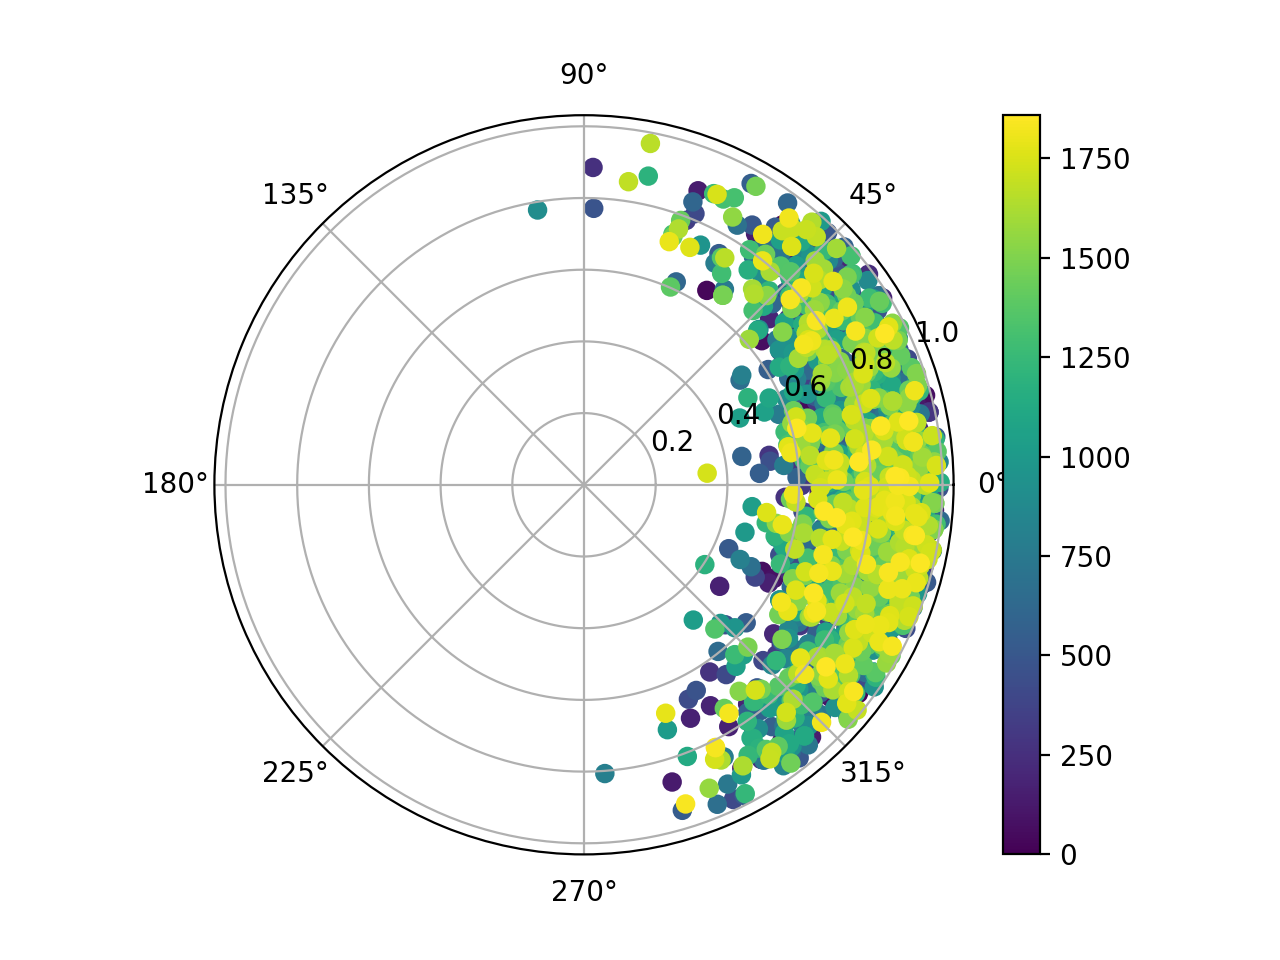

In [46]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='polar')
sc = ax.scatter(posterior['phi'], posterior['amp'], c=numpy.arange(posterior['amp'].shape[0]))
pyplot.colorbar(sc)
fig.show()

<IPython.core.display.Javascript object>


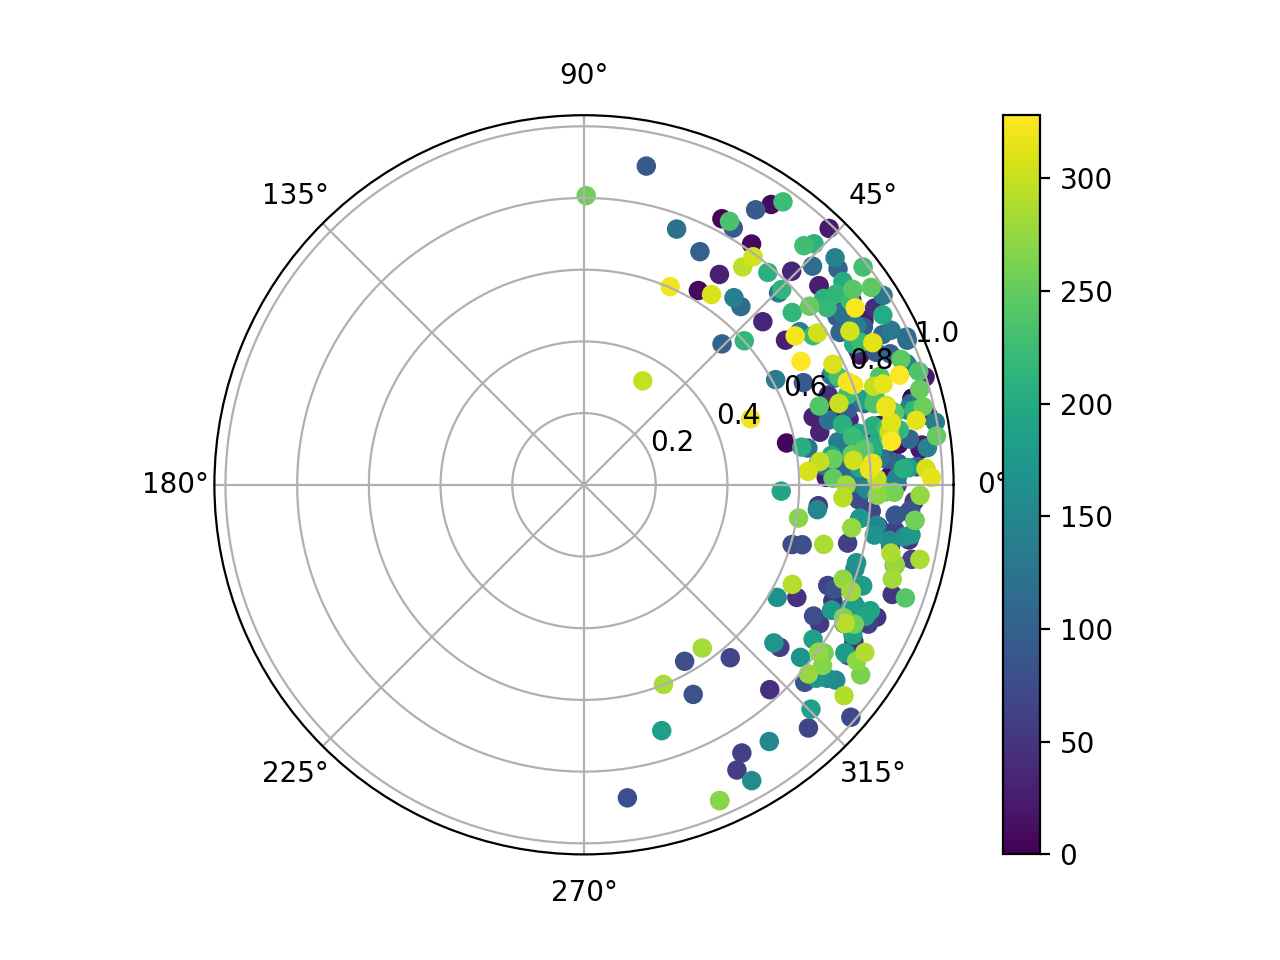

In [47]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='polar')
sc = ax.scatter(posterior_norm['phi'], posterior_norm['amp'], c=numpy.arange(posterior_norm['amp'].shape[0]))
pyplot.colorbar(sc)
fig.show()

<IPython.core.display.Javascript object>


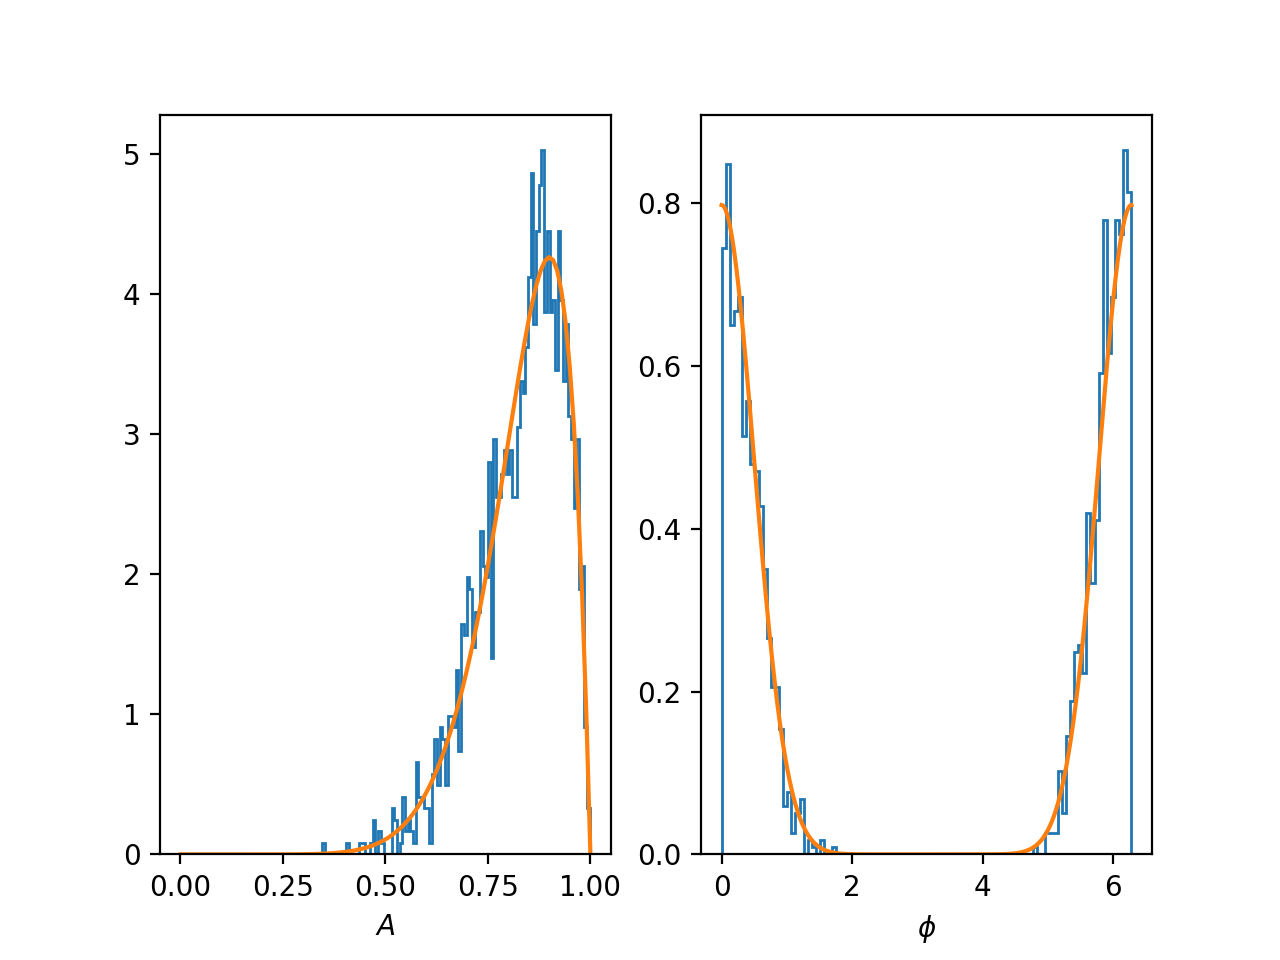

In [48]:
phis = numpy.linspace(0, 2*numpy.pi, num=1000)
amps = numpy.linspace(0, 1, num=100)
fig, (ax1, ax2) = pyplot.subplots(ncols=2)
ax1.hist(posterior['amp'],  histtype='step', bins=100, density=True)
ax1.plot(amps, model.ampdist.pdf(amps))
ax1.set_xlabel('$A$')
ax2.hist(posterior['phi'], histtype='step', bins=100, density=True)
ax2.plot(phis, numpy.exp(numpy.array([model._logpdf_phi(p) for p in phis])))
ax2.set_xlabel('$\phi$')
fig.show()

<IPython.core.display.Javascript object>


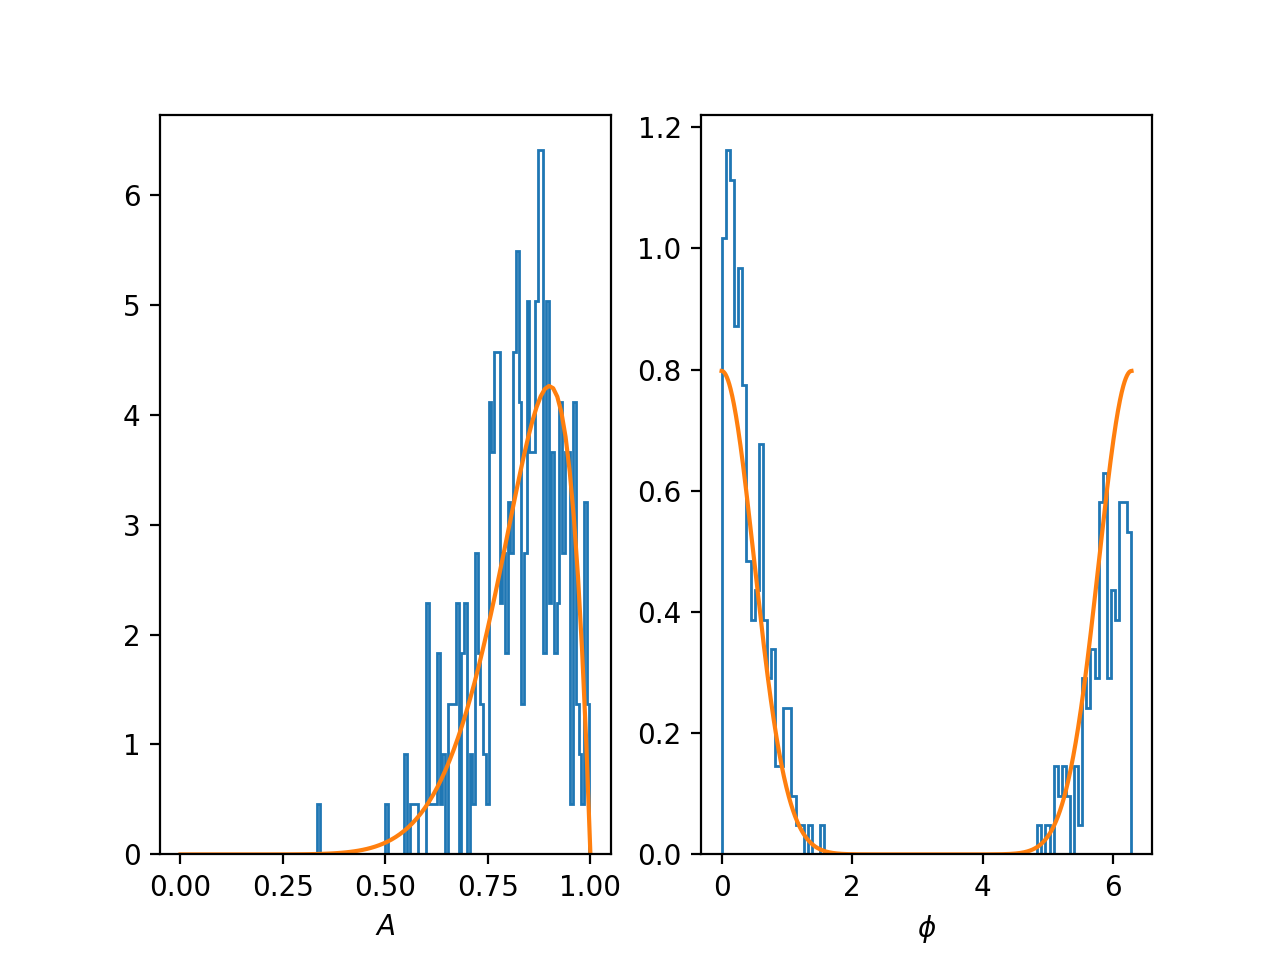

In [49]:
phis = numpy.linspace(0, 2*numpy.pi, num=1000)
amps = numpy.linspace(0, 1, num=100)
fig, (ax1, ax2) = pyplot.subplots(ncols=2)
ax1.hist(posterior_norm['amp'],  histtype='step', bins=100, density=True)
ax1.plot(amps, model.ampdist.pdf(amps))
ax1.set_xlabel('$A$')
ax2.hist(posterior_norm['phi'], histtype='step', bins=100, density=True)
ax2.plot(phis, numpy.exp(numpy.array([model._logpdf_phi(p) for p in phis])))
ax2.set_xlabel('$\phi$')
fig.show()

<IPython.core.display.Javascript object>


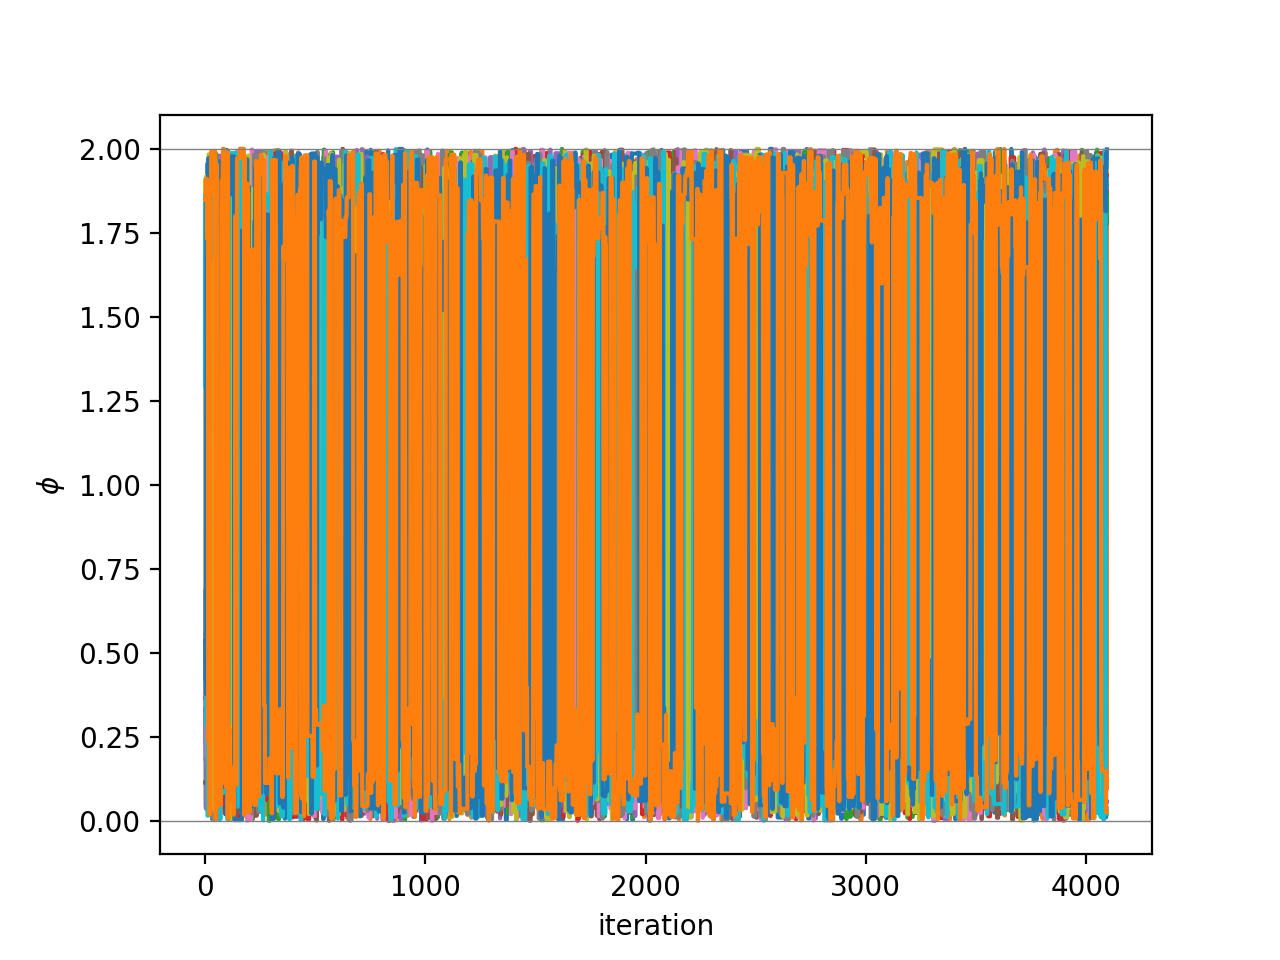

In [50]:
fig, ax = pyplot.subplots()
for ii in range(nchains):
    ax.plot(samples['phi'][ii,:]/numpy.pi)
ax.axhline(0, color='gray', lw=0.5)
ax.axhline(2, color='gray', lw=0.5)
ax.set_ylabel(r'$\phi$')
ax.set_xlabel('iteration')
fig.show()

<IPython.core.display.Javascript object>


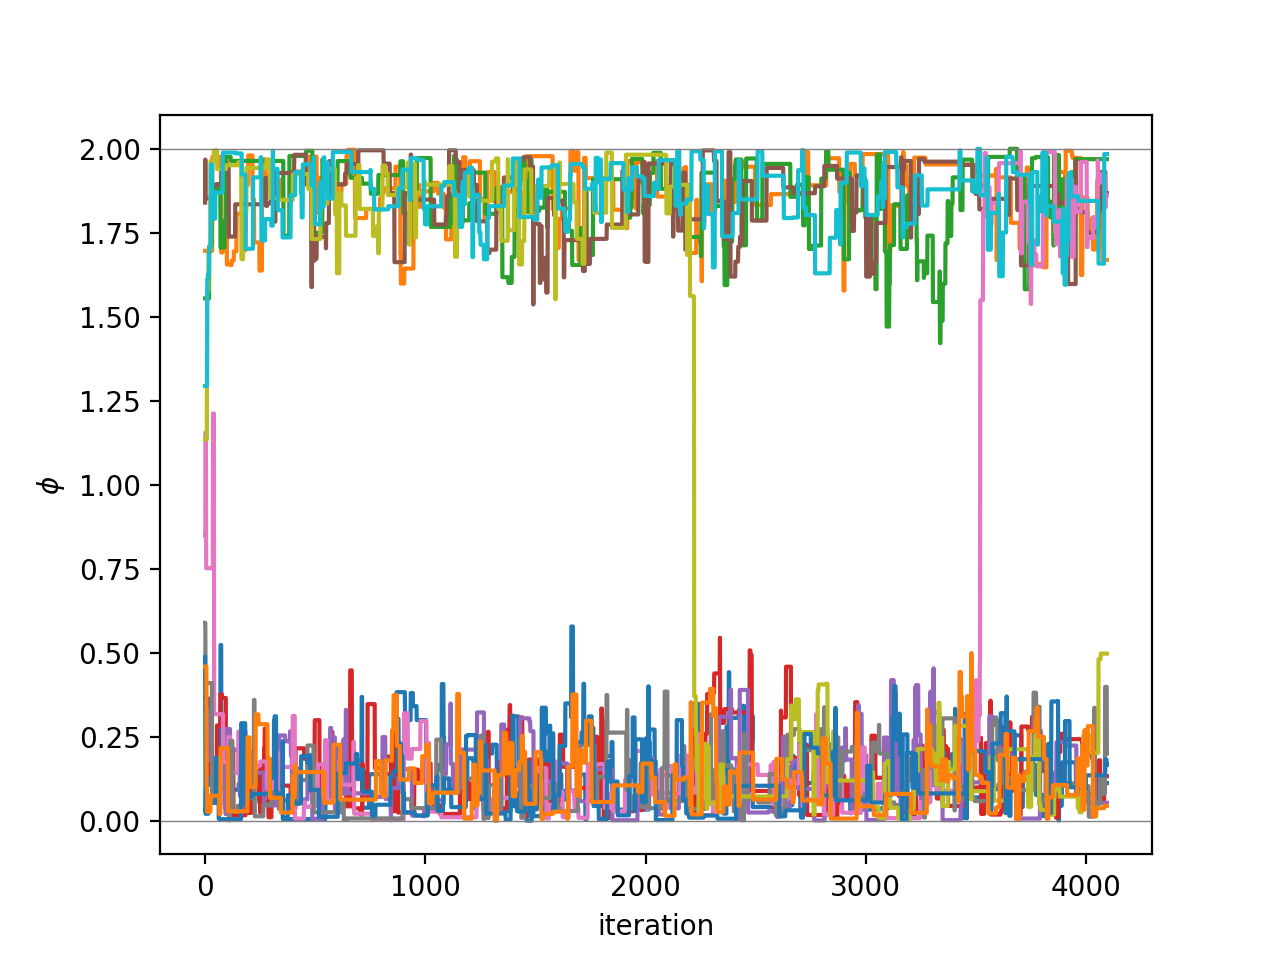

In [51]:
fig, ax = pyplot.subplots()
for ii in range(nchains):
    ax.plot(samples_norm['phi'][ii,:]/numpy.pi)
ax.axhline(0, color='gray', lw=0.5)
ax.axhline(2, color='gray', lw=0.5)
ax.set_ylabel(r'$\phi$')
ax.set_xlabel('iteration')
fig.show()

# With adaptation (Veitch et al. algorithm)
There is also an adaptive version of the angular proposal. Let's repeat the above tests with the adaptation.

In [52]:
from epsie.proposals import (AdaptiveAngular, AdaptiveBoundedNormal, AdaptiveNormal)

In [53]:
adaptation_duration = 2048

## 1D test

In [54]:
model = AngularModel()

In [55]:
prior_widths = {p: abs(bnds) for p, bnds in model.prior_bounds.items()}
prop = AdaptiveAngular(model.params, adaptation_duration=adaptation_duration)
prop_norm = AdaptiveNormal(model.params, prior_widths, adaptation_duration=adaptation_duration)

In [56]:
pool.close()
pool = multiprocessing.Pool(nprocs)

sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                    proposals=[prop])
sampler.start_position = model.prior_rvs(size=nchains)

sampler_norm = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                         proposals=[prop_norm])
sampler_norm.start_position = sampler.start_position

In [57]:
print(sampler.chains[0].proposal_dist.proposals)
print(sampler_norm.chains[0].proposal_dist.proposals)

(<epsie.proposals.angular.AdaptiveAngular object at 0x11e3d1438>,)
(<epsie.proposals.normal.AdaptiveNormal object at 0x11ddfc128>,)


In [58]:
# run both for some iterations
sampler.run(2*adaptation_duration)
sampler_norm.run(2*adaptation_duration)

In [59]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples['phi'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = calculate_acl(sx)
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['phi'].append(sx[::-1][::acl][::-1])

In [60]:
print(acls, acls.mean())

[4 4 4 3 4 4 4 6 4 4 4 4] 4.083333333333333


In [61]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples_norm = sampler_norm.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler_norm.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls_norm = numpy.zeros(nchains, dtype=int)
thinned_arrays_norm = {'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples_norm['phi'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = calculate_acl(sx)
    acls_norm[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays_norm['phi'].append(sx[::-1][::acl][::-1])

In [62]:
print(acls_norm, acls_norm.mean())

[10 11 21 11 14  9 12 11 14 17 17 15] 13.5


In [63]:
# create a flattened posterior array
posterior = {'phi': numpy.concatenate(thinned_arrays['phi'])}
print("Number of independent samples:", posterior['phi'].size)

Number of independent samples: 6145


In [64]:
# create a flattened posterior array
posterior_norm = {'phi': numpy.concatenate(thinned_arrays_norm['phi'])}
print("Number of independent samples:", posterior_norm['phi'].size)

Number of independent samples: 1936


<IPython.core.display.Javascript object>


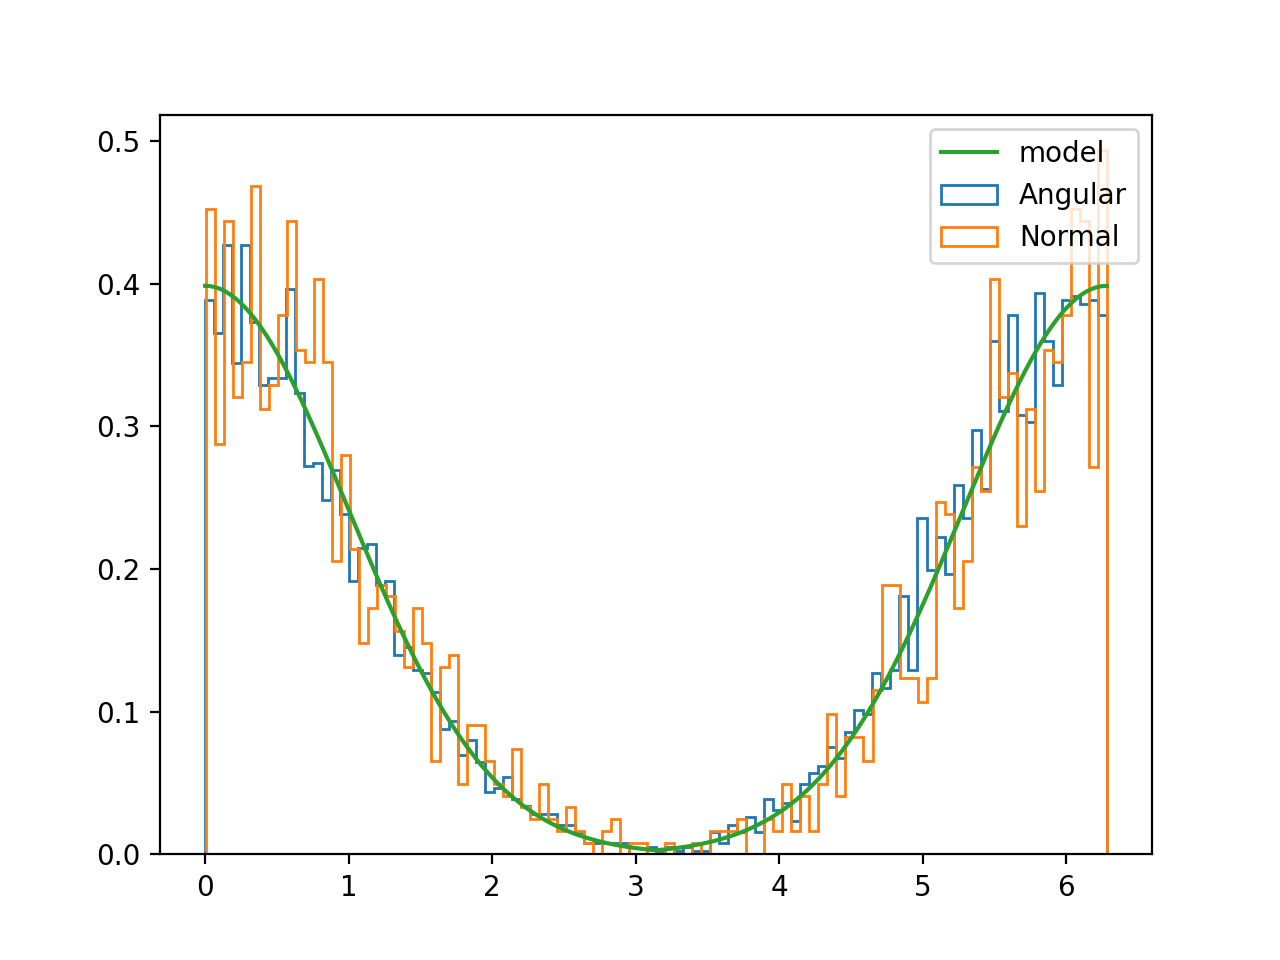

In [65]:
fig, ax = pyplot.subplots()
ax.hist(posterior['phi'], histtype='step', bins=100, density=True, label='Angular')
ax.hist(posterior_norm['phi'], histtype='step', bins=100, density=True, label='Normal')
xpts = numpy.linspace(model.prior_bounds['phi'][0], model.prior_bounds['phi'][1],
                      num=1000)
postpdf = numpy.exp(numpy.array([sum(model(phi=pt)) for pt in xpts]))
norm = (numpy.diff(xpts)[0] * postpdf).sum()
ax.plot(xpts, postpdf/norm, label='model')
ax.set_label('phi')
ax.legend()
fig.show()

In [66]:
ar = sampler.acceptance['acceptance_ratio']
ar[ar > 1] = 1.
ar.mean()

0.5086917851553077

In [67]:
ar_norm = sampler_norm.acceptance['acceptance_ratio']
ar_norm[ar_norm > 1] = 1.
ar_norm.mean()

0.2503235937010218

## 2D test

In [68]:
model = PolarModel()

In [69]:
prior_widths = {p: abs(bnds) for p, bnds in model.prior_bounds.items()}
ampprop = AdaptiveBoundedNormal(['amp'], boundaries={'amp': model.prior_bounds['amp']},
                                adaptation_duration=adaptation_duration)
phiprop = AdaptiveAngular(['phi'], adaptation_duration=adaptation_duration)
prop_norm = AdaptiveNormal(model.params, prior_widths, adaptation_duration=adaptation_duration)

In [70]:
pool.close()
pool = multiprocessing.Pool(nprocs)

sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                    proposals=[ampprop, phiprop])
sampler.start_position = model.prior_rvs(size=nchains)

sampler_norm = MetropolisHastingsSampler(model.params, model, nchains, pool=pool,
                                         proposals=[prop_norm])
sampler_norm.start_position = sampler.start_position

In [71]:
print(sampler.chains[0].proposal_dist.proposals)
print(sampler_norm.chains[0].proposal_dist.proposals)

(<epsie.proposals.bounded_normal.AdaptiveBoundedNormal object at 0x11e3d1470>, <epsie.proposals.angular.AdaptiveAngular object at 0x11e3d1438>)
(<epsie.proposals.normal.AdaptiveNormal object at 0x11e003470>,)


In [72]:
# run both for some iterations
sampler.run(2*adaptation_duration)
sampler_norm.run(2*adaptation_duration)

In [73]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'amp': [], 'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sp = samples['phi'][ii, burnin_iter:]
    sa = samples['amp'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = max(calculate_acl(sp), calculate_acl(sa))
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['amp'].append(sa[::-1][::acl][::-1])
    thinned_arrays['phi'].append(sp[::-1][::acl][::-1])

In [74]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples_norm = sampler_norm.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler_norm.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls_norm = numpy.zeros(nchains, dtype=int)
thinned_arrays_norm = {'amp': [], 'phi': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sp = samples_norm['phi'][ii, burnin_iter:]
    sa = samples_norm['amp'][ii, burnin_iter:]
    # compute the acl for each parameter
    acl = max(calculate_acl(sp), calculate_acl(sa))
    acls_norm[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays_norm['amp'].append(sa[::-1][::acl][::-1])
    thinned_arrays_norm['phi'].append(sp[::-1][::acl][::-1])

In [75]:
print(acls, acls.mean())

[12 11 11 12 12 12 12 10 12 11 20  9] 12.0


In [76]:
print(acls_norm, acls_norm.mean())

[13 18 11 12 29 20 15 13 23 10 23 30] 18.083333333333332


In [77]:
samples.shape

(12, 4096)

In [78]:
# create a flattened posterior array
posterior = {'amp': numpy.concatenate(thinned_arrays['amp']),
             'phi': numpy.concatenate(thinned_arrays['phi'])}
print("Number of independent samples:", posterior['phi'].size)

Number of independent samples: 2123


In [79]:
# create a flattened posterior array
posterior_norm = {'amp': numpy.concatenate(thinned_arrays_norm['amp']),
                  'phi': numpy.concatenate(thinned_arrays_norm['phi'])}
print("Number of independent samples:", posterior_norm['phi'].size)

Number of independent samples: 1553


<IPython.core.display.Javascript object>


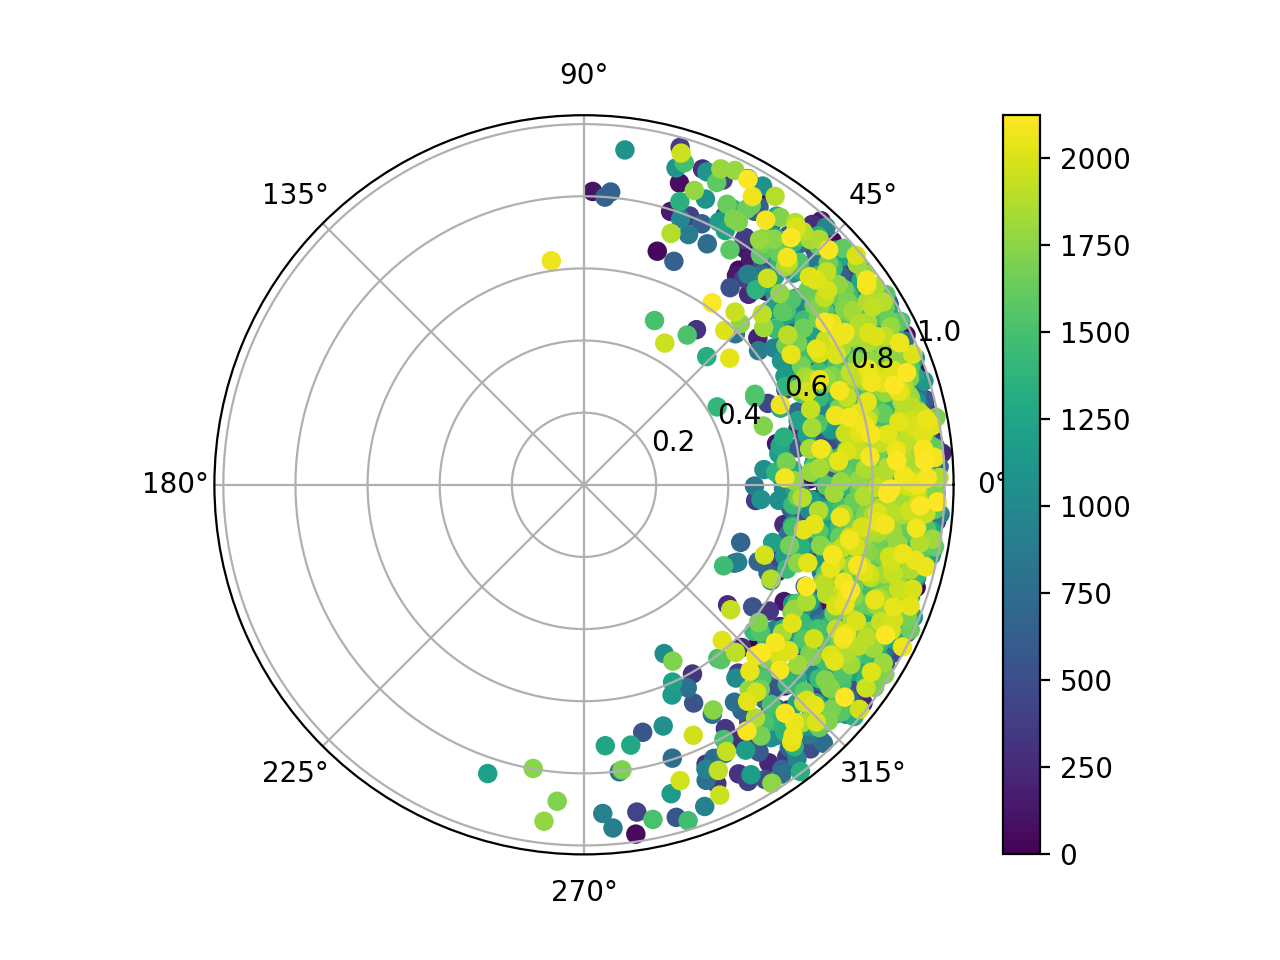

In [80]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='polar')
sc = ax.scatter(posterior['phi'], posterior['amp'], c=numpy.arange(posterior['amp'].shape[0]))
pyplot.colorbar(sc)
fig.show()

<IPython.core.display.Javascript object>


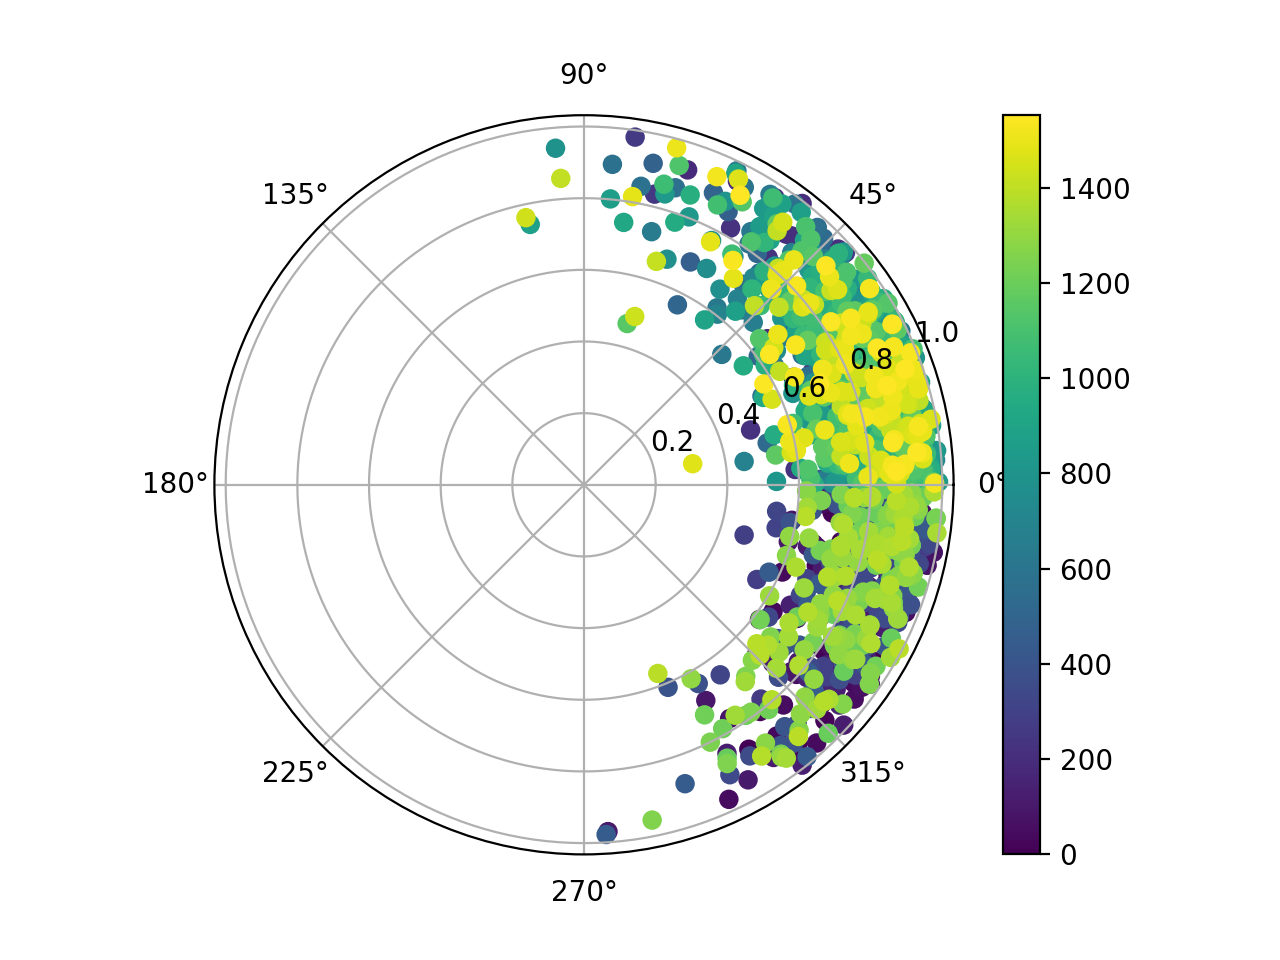

In [81]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='polar')
sc = ax.scatter(posterior_norm['phi'], posterior_norm['amp'], c=numpy.arange(posterior_norm['amp'].shape[0]))
pyplot.colorbar(sc)
fig.show()

<IPython.core.display.Javascript object>


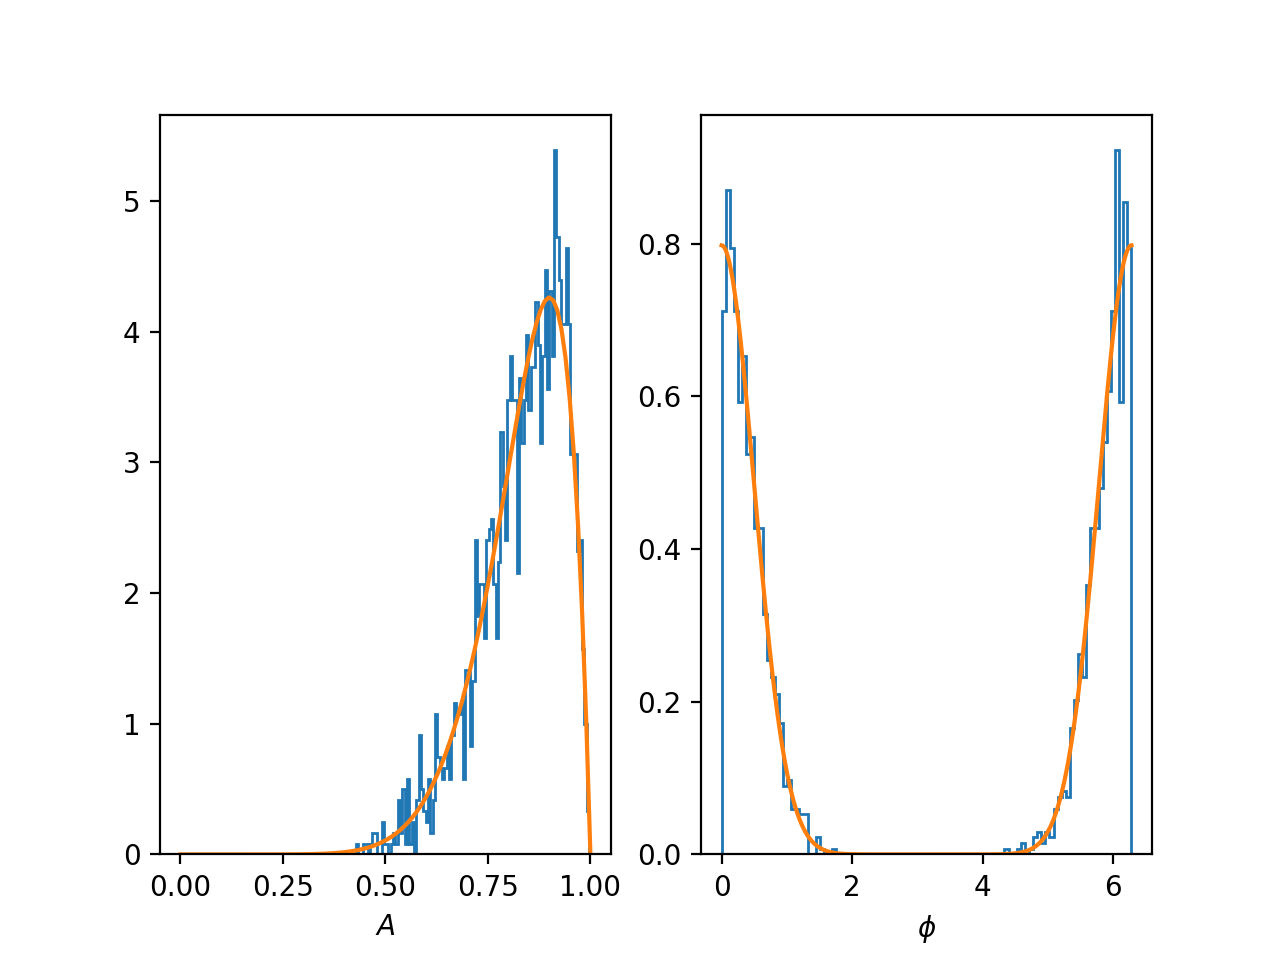

In [82]:
phis = numpy.linspace(0, 2*numpy.pi, num=1000)
amps = numpy.linspace(0, 1, num=100)
fig, (ax1, ax2) = pyplot.subplots(ncols=2)
ax1.hist(posterior['amp'],  histtype='step', bins=100, density=True)
ax1.plot(amps, model.ampdist.pdf(amps))
ax1.set_xlabel('$A$')
ax2.hist(posterior['phi'], histtype='step', bins=100, density=True)
ax2.plot(phis, numpy.exp(numpy.array([model._logpdf_phi(p) for p in phis])))
ax2.set_xlabel('$\phi$')
fig.show()

<IPython.core.display.Javascript object>


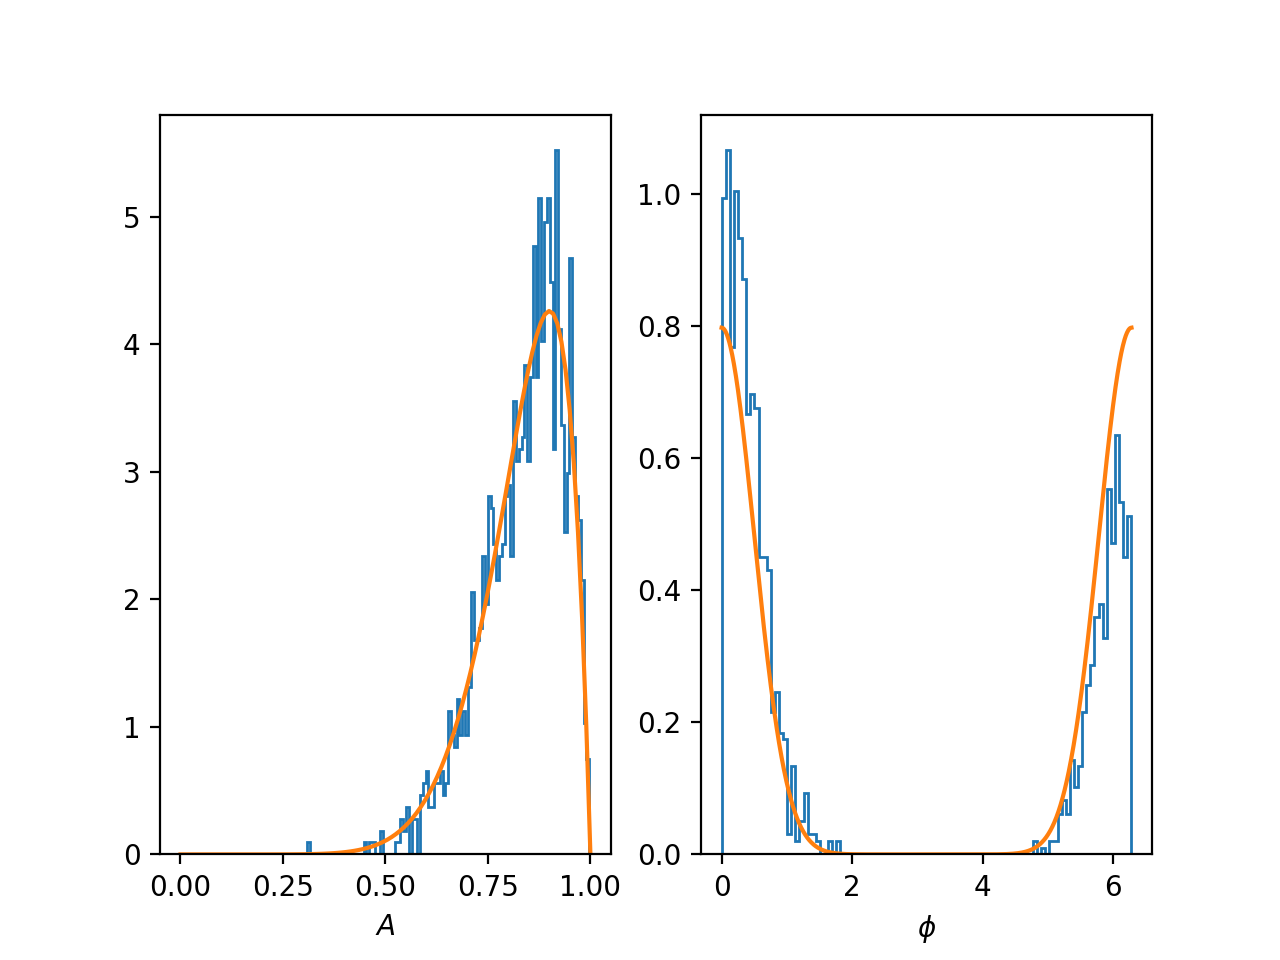

In [83]:
phis = numpy.linspace(0, 2*numpy.pi, num=1000)
amps = numpy.linspace(0, 1, num=100)
fig, (ax1, ax2) = pyplot.subplots(ncols=2)
ax1.hist(posterior_norm['amp'],  histtype='step', bins=100, density=True)
ax1.plot(amps, model.ampdist.pdf(amps))
ax1.set_xlabel('$A$')
ax2.hist(posterior_norm['phi'], histtype='step', bins=100, density=True)
ax2.plot(phis, numpy.exp(numpy.array([model._logpdf_phi(p) for p in phis])))
ax2.set_xlabel('$\phi$')
fig.show()